### Notebook configuration

In [2]:
run_number          = 4734
input_dst_filename  = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"

Zrange  =   80,  520
XYrange = -200,  200
Erange  =  6e3, 14e3
Znbins  =   10
XYnbins =   60
Enbins  =   50

# Plotting style
default_cmap = "jet"
figure_size  = 16, 12
font_size    = 14

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [3]:
import os
import time
import functools
import operator

import numpy             as np
import pandas            as pd
import scipy.stats       as st
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf

from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import hist2d
from invisible_cities.icaro. hst_functions import labels
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
from icaro           .core . fit_functions import expo_seed

### Plotting configuration

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 30

### Initialization

In [5]:
Zbins     = np.linspace(* Zrange,  Znbins+1)
Ebins     = np.linspace(* Erange,  Enbins+1)
XYbins    = np.linspace(*XYrange, XYnbins+1)

Xcenters  = shift_to_bin_centers(XYbins)
Ycenters  = shift_to_bin_centers(XYbins)
Zcenters  = shift_to_bin_centers( Zbins)

input_dst_filename = os.path.expandvars( input_dst_filename)

### Read data

In [6]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 912570 
Total number of events: 909421


In [7]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values

### Compute residuals

In [8]:
def compute_residuals(Z, E, bins, xbin, ybin):
    sel  = np.all(bins == (xbin, ybin), axis=1)
    size = np.count_nonzero(sel)
    if size < 50: return np.full(Znbins, np.nan)

    z = Z[sel]
    e = E[sel]

    allx, ally, allu = fitf.profileX(z, e, Znbins, Zrange, drop_nan=False)
    ok               = allu > 0
    x   ,    y,   yu = allx[ok], ally[ok], allu[ok]

    seed     = expo_seed(x, y)
    f        = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
    assert np.all(f.values != seed)

    return np.where(ok, (f.fn(allx) - ally) / allu, np.nan)

In [9]:
coords     = zip(*[(x, y, z) for x in Xcenters for y in Ycenters for z in Zcenters])
xs         = next(coords)
ys         = next(coords)
zs         = next(coords)
*_, bins   = st.binned_statistic_2d(X, Y, Z, "count", bins=(XYbins, XYbins), expand_binnumbers=True)
starconcat = lambda x, y: np.concatenate([x, y])
residuals  = functools.reduce(starconcat,
                              map(functools.partial(compute_residuals, Z, E, bins.T - 1),
                                  np.repeat(np.arange(XYnbins), XYnbins),
                                  np.tile  (np.arange(XYnbins), XYnbins)))

data       = pd.DataFrame(dict(x=xs, y=ys, z=zs, r=residuals))

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


### Residuals distribution

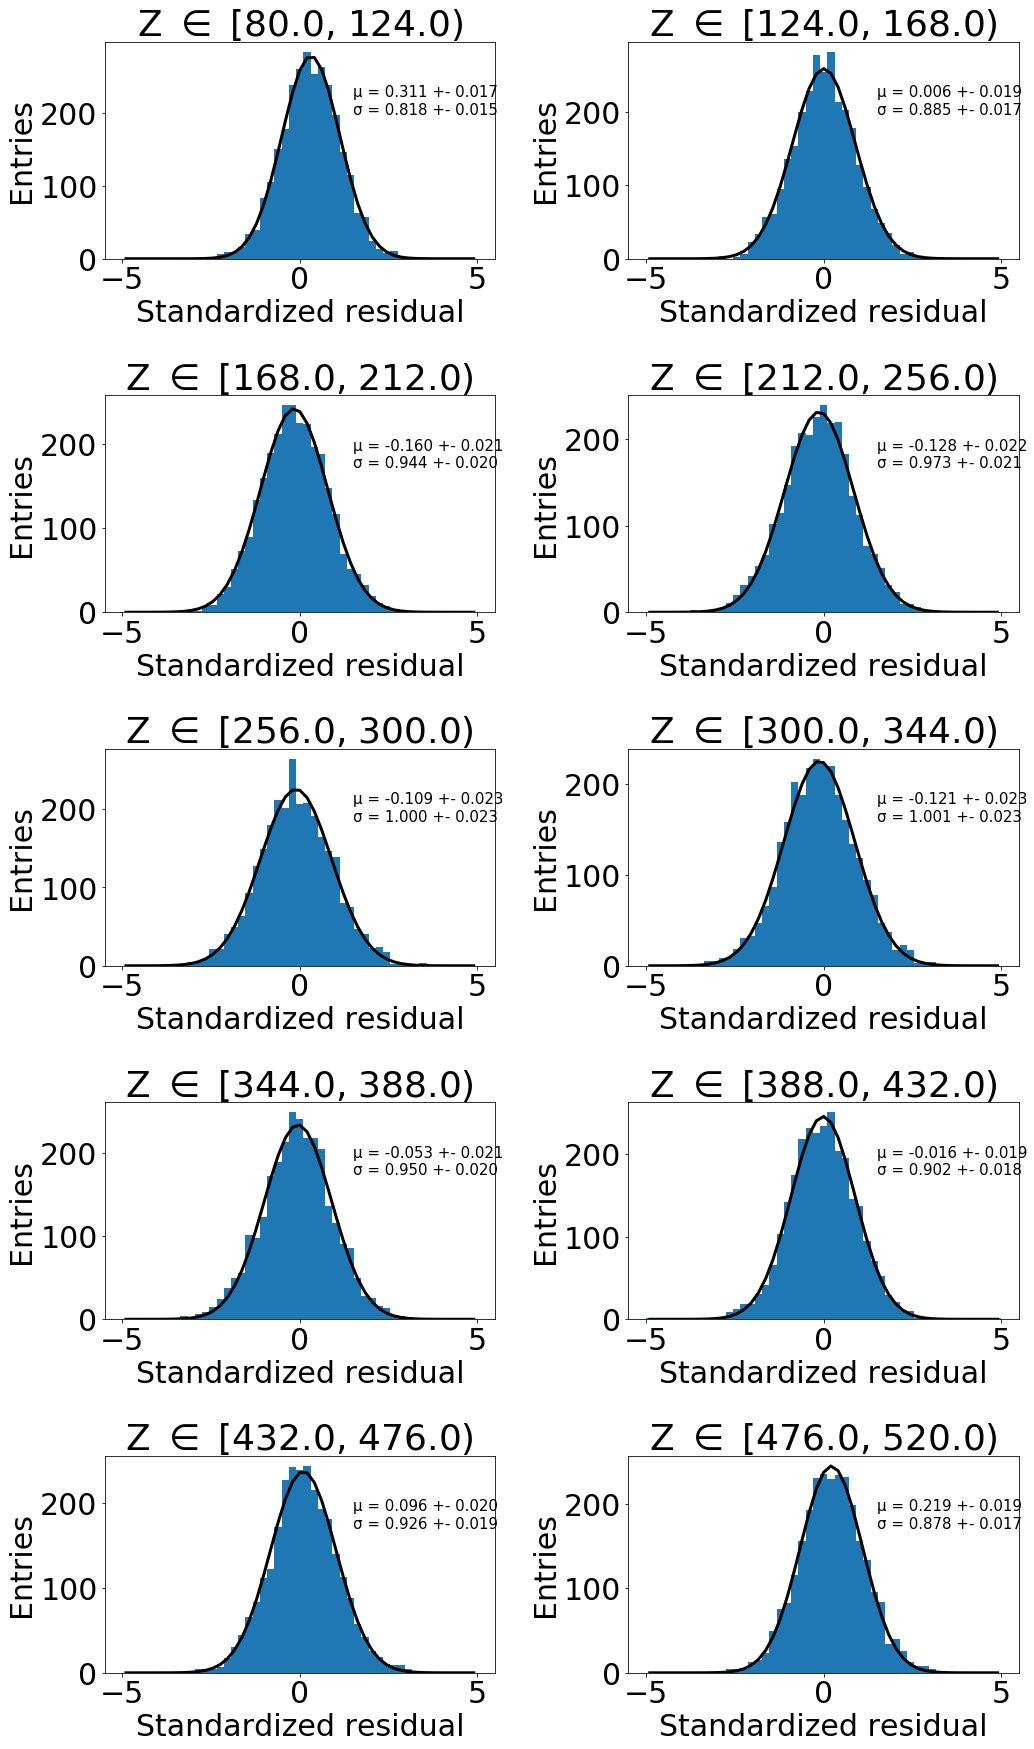

In [10]:
Rbins = np.linspace(-5, 5, 50)
Zresiduals = pd.DataFrame(dict(zmin    = Zbins[ :-1],
                               zmax    = Zbins[1:  ],
                               z       = Zcenters   ,
                               zu      = np.diff(Zbins) / 2,
                               mu      = np.zeros_like(Zcenters),
                               muu     = np.zeros_like(Zcenters),
                               sigma   = np.zeros_like(Zcenters),
                               sigmau  = np.zeros_like(Zcenters)))


plt.figure(figsize=(15, 25))
residuals = data.groupby("z").r
for i, z in enumerate(Zcenters):
    plt.subplot(5, 2, i + 1)
    y, x, _ = hist(residuals.get_group(z).dropna(), Rbins, new_figure=False)
    f       = fitf.fit(fitf.gauss, x, y, 
                       seed      = (1, 0, 1),
                       sigma     = poisson_sigma(y),
                       fit_range = (-2, 2),
                       maxfev    = int(1e4))
    plt.plot(x, f.fn(x), "k-", lw=3)

    _, mu, sig = map(measurement_string, f.values, f.errors)
    Zresiduals.mu    [i] = f.values[1]
    Zresiduals.muu   [i] = f.errors[1]
    Zresiduals.sigma [i] = f.values[2]
    Zresiduals.sigmau[i] = f.errors[2]

    plt.text(1.5, plt.ylim()[1] / 1.5,
             f"µ = {mu}\nσ = {sig}",
             fontsize=15)
    labels("Standardized residual", "Entries", f"Z $\in$ [{Zresiduals.zmin[i]}, {Zresiduals.zmax[i]})")
plt.tight_layout()

### Average residuals vs z

In [11]:
plt.rcParams[  "font.size"   ] = 25

In [12]:
np

<module 'numpy' from '/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/__init__.py'>

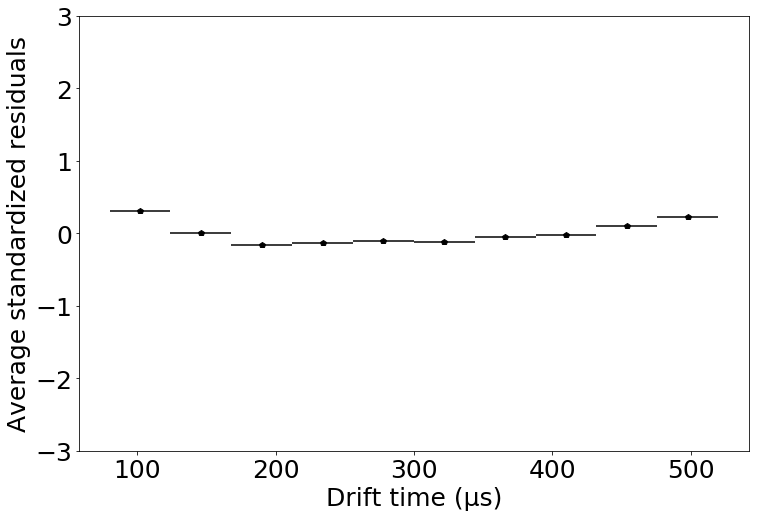

In [15]:
plt.errorbar(Zresiduals.z, Zresiduals.mu, Zresiduals.muu, Zresiduals.zu, "p", color="k")
plt.ylim(-3, 3)
labels("Drift time (µs)", "Average standardized residuals")
plt.savefig("/Users/Gonzalo/github/papers/KrRunII/imgKr/LifetimeResidualsVsZ.png")

### Average residual sigma vs z

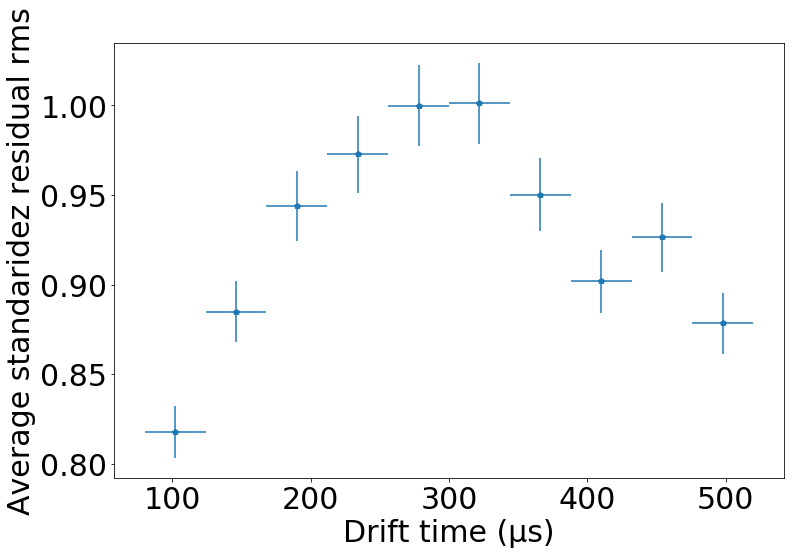

In [11]:
plt.errorbar(Zresiduals.z, Zresiduals.sigma, Zresiduals.sigmau, Zresiduals.zu, "p")
labels("Drift time (µs)", "Average standaridez residual rms")

### Average residual in XY

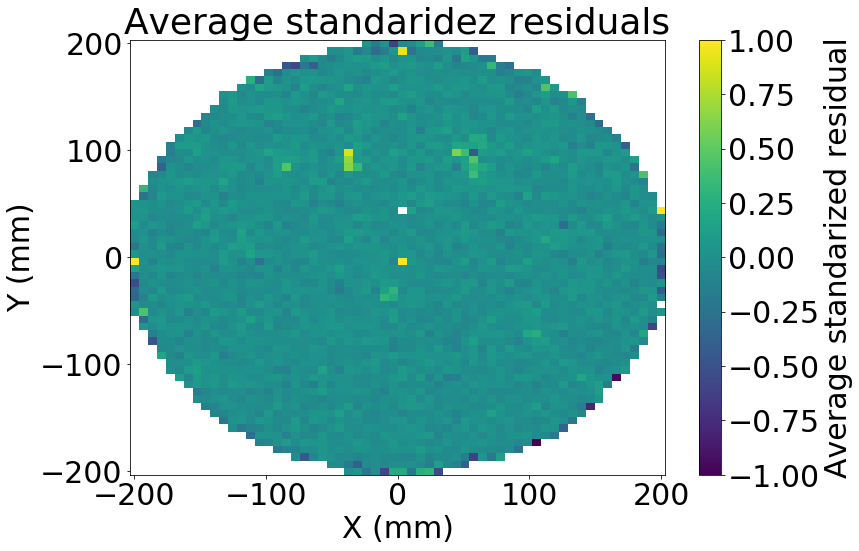

In [12]:
*_, cb = display_matrix(Xcenters, Ycenters, data.groupby(("x", "y")).r.mean().values, vmin=-1, vmax=+1)
cb.set_label("Average standarized residual")
labels("X (mm)", "Y (mm)", "Average standaridez residuals")

### Lifetime vs Z for a particular XY bin

Fit the lifetime along Z using a moving window

In [13]:
def lifetime_and_error(z, e, i, n=5):
    slice_ = slice(i, i + n)
    zave   = np.mean(z[slice_])
    f = fitf.fit(fitf.expo, z[slice_], e[slice_], (1e4, -1e3))
    return zave, -f.values[1], f.errors[1]

N   = 5
sel = in_range(X, 5, 15) & in_range(Y, 5, 15)

zp,  ep, ue   = fitf.profileX(Z[sel], E[sel], Znbins * 2, Zrange)
uz            = np.diff(zp)[0] / 2
zs, lts, ults = list(map(np.array,
                         zip(*map(functools.partial(lifetime_and_error, zp, ep, n=N),
                                  range(len(x) - N)))))

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:66: RuntimeWarning: invalid value encountered in double_scalars
  return chi2 / ndf, pvalue


TypeError: Improper input: N=2 must not exceed M=1

In [ ]:
hist2d(Z[sel], E[sel], (np.linspace(100, 500), np.linspace(6e3, 12e3)));
plt.errorbar(zp, ep, ue, fmt="kp")
labels("Drift time (µs)", "Energy (pes)")

In [ ]:
plt.errorbar(zs, lts, ults, uz, fmt="kp")
labels("Drift time (µs)", "Lifetime (µs)")